## "Active Sciencing" with Reusable Workflows

By Kyle Cranmer, Tim Head, & Lukas Heinrich June, 2016

Based on earlier work with NYU CDS masters students Manoj Kumar, Phil Yeres, and Michele Ceru and discussions with Brenden Lake and Gilles Louppe.

The point of this notebook is to explore the synergy of three powerful techniques:

   1. generic likelihood-free inference engines (eg. ABC, carl, etc.) that enable statistical inference on the parameters of a theory that are implicitly defined by a simulator
 
   2. workflows that encapsulate scientific pipelines and extend the scope from reproducibility to reusability
 
   1. active learning and sequential design algorithms (eg. Bayesian optimization) that balance exploration and exploitation to efficiently optimize an expensive black box objective function
 
Together, these three ideas can be combined to enable an efficient and automated loop of the scientific method -- at least, for a sufficiently well posed problem. The scientist's input to the system are:

 * an external workflow that implements some experimental protocol 
 * an external workflow that implements a simulator for those experiments, which depends on some theoretical parameters that we would like to infer.
 
Interesingly, we will use the simulator not only to perform inference on the parameters, but also to design the next experiment (this is where active learning comes in).

Notation:

   * $\phi$ : Parameters that specify the experimental configuration

   * $\theta$: Parameters of the theory / simulator, which we would like to infer from the experimental data

   * $X$ : Data generated from the experiment or simulator

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import emcee
from scipy.stats import norm

from prior_dist import Distribution

## Step 1: Perform Experiment, Collect Data

In [2]:
def simulator(theta, phi, n_samples=100):
    return np.random.normal(loc=theta, scale=2 + np.sin(phi), size=n_samples)

def collect_data(phi, n_samples=100):
    # 3.141 is the unknown parameter we are trying to measure
    # best experimental setting is 3pi/2 (or any multiple of it)
    return simulator(3.141, phi, n_samples)

## Step 2: Bayesian Prior → Posterior Update 

In [3]:
def lnprior(theta, prior):
    p = prior.pdf(theta)
    if p <= 1e-8:
        return -np.inf
    else:
        return np.log(p)

def lnlike(theta, x, phi):
    #exact likelihood for testing
    #mean, std = theta, 2 + np.sin(phi)
    #return np.log(norm(mean, std).pdf(x).prod())
    
    #approx likelihood
    simdata = simulator(theta, phi,n_samples=1000)
    # this xrange is specific to this simulator
    # better to have auto-range, but would need density to correct for range & bin width
    xrange = (3-9,3+9) 
    approx_density = Distribution(name='approx density', range=xrange,samples=simdata)
    return np.sum(np.log(approx_density.pdf(x)))

def lnprob(theta, x, prior, phi):
    lp = lnprior(theta, prior)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, phi)

def calculate_posterior(prior, data, phi):
    """Compute samples from the posterior"""
    ndim, n_walkers = 1, 10
    # initialise walkers from the MAP + noise
    # XXX alternatively sample a point from the KDE without adding noise?
    # XXX not sure if the noise takes us into a region where the prior is zero?
    pos = [prior.map() + 1e-1*np.random.randn(ndim) for i in range(n_walkers)]
    
    sampler = emcee.EnsembleSampler(n_walkers, 1, lnprob, args=(data, prior, phi))
    pos, prob, state = sampler.run_mcmc(pos, 100)
    
    sampler.reset()
    pos, prob, state = sampler.run_mcmc(pos, 300)
    
    return Distribution(prior.name, prior.range, sampler.flatchain)

## Step 3: Optimize Experimental Configuration

Based on the updated posterior $p(\theta)$ we will consider future experiments with configuration $\phi$. For each of those configurations, we will run several simulations of the experiment and perform inference on those simulated datasets to estimate the expected information gain (EIG)

\begin{equation}
EIG(\phi) =  \int dx d\theta \; p(x | \theta) p(\theta) \big [ H\left [P(\theta) \right] - H\left[ P(\theta\, |\, x) \right] \big ] \approx \int dx  \; p(x | \theta_{MAP}) \big [ H\left [P(\theta) \right] - H\left[ P(\theta\, |\, x) \right] \big ]
\end{equation}
where
\begin{equation}
H\left [P(\theta) \right] = \int P(\theta) \log P(\theta) d\theta 
\end{equation}

To efficiently optimize $EIG[\phi]$ we will use an active learning procedure like Bayesian Optimization.

In [11]:
from multiprocessing import Pool

def info_gain(p1, p2):
    return p1.entropy() - p2.entropy()

def _simulate(args):
    theta_map, phi, prior = args
    # external workflow provides simulated data
    sim_data = simulator(theta_map, phi)

    #external workflow uses simulator to provide likelihood 
    sim_posterior = calculate_posterior(prior, sim_data, phi)
    return info_gain(prior, sim_posterior)


def expected_information_gain(phi, prior):
    'calculate the expression above using workflow for simulations'
    n_simulations = 4
    
    #need to pass in prior through some extra arguments
    
    # use saddle-point approximation
    theta_map = prior.map()

    use_pool = True
    if use_pool:
        # currently the MCMC sampler is the slower part, which already uses threads so we don't gain
        # this should change once we have a more realistic simulator that takes time to run
        # also having problems with OSError: [Errno 24] Too many open files
        pool = Pool(4)
        eig = pool.map(_simulate, [(theta_map, phi, prior) for i in range(n_simulations)])
        pool.close()
        pool.join()
    else:
        eig = []
        for i in range(n_simulations):
            eig.append( _simulate((theta_map, phi, prior)) )
    return np.mean(eig)

In [5]:
#use scikit-optimize to optimize phi
from skopt import gp_minimize


def design_next_experiment(prior):
    bounds = [(0., 2*np.pi)]
    n_calls = 5
    
    func = lambda p: -expected_information_gain(p, prior)

    # five random points to initialise things, then five using the GP model
    # XXX Should we be reusing the random number generator? Means this call eseentially evaluates
    # XXX the same values of phi each science iteration
    opt_result = gp_minimize(func, bounds, n_random_starts=5, n_calls=n_calls, random_state=4)

    return opt_result.x[0], opt_result.x_iters

## Run the loop

### Initialize

In [6]:
tempdata = np.random.uniform(0., 2*np.pi, 100000)
prior_theta = Distribution('p(theta)', range=(0., 2*np.pi), samples=tempdata)

n_science_iterations = 5
phi_history = []
prior_history = []

phi = 1.2345

In [7]:
for i_experiment in range(n_science_iterations):
    print("Experimental settings ({}):".format(i_experiment), phi)
    
    phi_history.append(phi)
    prior_history.append(prior_theta)

    # run experiment with configuration given by phi
    real_data = collect_data(phi)

    # update new prior = posterior from previous experiment
    prior_theta = calculate_posterior(prior_theta, real_data, phi)

    #design new experiment given current knowledge
    phi, phi_iter = design_next_experiment(prior_theta)
    
    print('next phi:', phi, "phi's tested in gp_min:", phi_iter)

Experimental settings (0): 1.2345
next phi: 4.38395949911 phi's tested in gp_min: [[6.0760276760949736], [3.4383616276357367], [6.1115560790547407], [4.4913213487917441], [4.3839594991052548]]
Experimental settings (1): 4.38395949911
next phi: 4.38395949911 phi's tested in gp_min: [[6.0760276760949736], [3.4383616276357367], [6.1115560790547407], [4.4913213487917441], [4.3839594991052548]]
Experimental settings (2): 4.38395949911
next phi: 4.49132134879 phi's tested in gp_min: [[6.0760276760949736], [3.4383616276357367], [6.1115560790547407], [4.4913213487917441], [4.3839594991052548]]
Experimental settings (3): 4.49132134879
next phi: 4.38395949911 phi's tested in gp_min: [[6.0760276760949736], [3.4383616276357367], [6.1115560790547407], [4.4913213487917441], [4.3839594991052548]]
Experimental settings (4): 4.38395949911
next phi: 4.49132134879 phi's tested in gp_min: [[6.0760276760949736], [3.4383616276357367], [6.1115560790547407], [4.4913213487917441], [4.3839594991052548]]


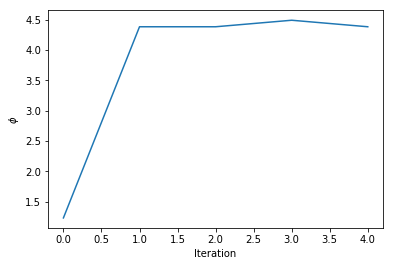

In [8]:
plt.plot(phi_history)
plt.xlabel('Iteration')
plt.ylabel('$\phi$')

0 1.2345


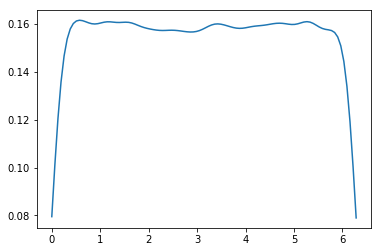

1 4.38395949911


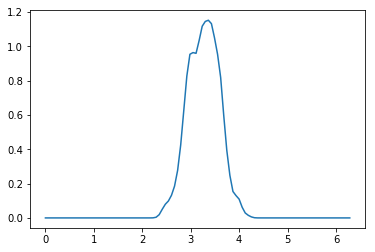

2 4.38395949911


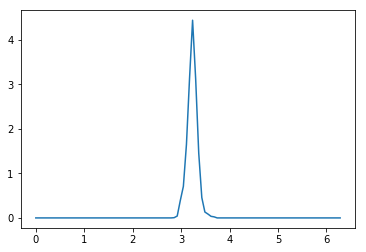

3 4.49132134879


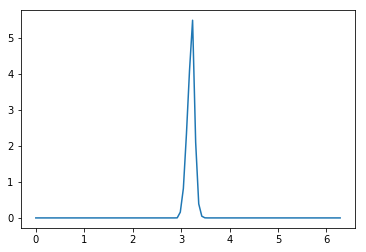

4 4.38395949911


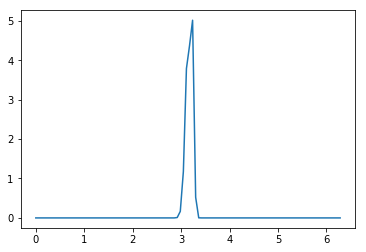

In [9]:
for n,prior in enumerate(prior_history):
    print(n, phi_history[n])
    prior.plot()
    plt.show()

## prototyping approx likelihood

-594.16582888378412

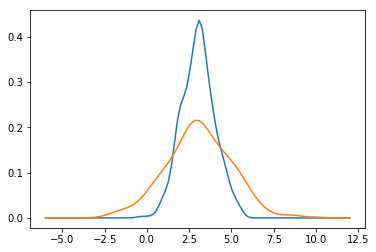

In [10]:
xrange = (3-9,3+3*3)
xtest = np.linspace(xrange[0], xrange[1],100)

simdata = simulator(theta=3,phi=1.5*np.pi,n_samples=500)
approx_density = Distribution(name='approx density', range=xrange,samples=simdata)
density = approx_density.pdf(xtest)
plt.plot(xtest,density)
np.sum(np.log(density))

simdata = simulator(theta=3,phi=0,n_samples=500)
approx_density = Distribution(name='approx density', range=xrange,samples=simdata)
density = approx_density.pdf(xtest)
plt.plot(xtest,density)
np.sum(np.log(density))
